In [1]:
from sklearn.model_selection import train_test_split
from experiment import tune_architecture, tune_hyperparameters, train_final_model
from model import predict
import pandas as pd
import torch
import preprocessing
import numpy as np

# Data preprocessing
## Assign labels

In [2]:
df = pd.read_csv("train_data.csv")
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Check for duplicated rows

In [3]:
df.duplicated().sum()

np.int64(307)

In [4]:
df["Label"] = df["SalePrice"].apply(preprocessing.classify)
df = df.drop(columns=["SalePrice"])
df.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),Label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0


## Check for missing values

In [5]:
preprocessing.missing(df, df.columns)

{}

# Categorical data

In [6]:
numeric_columns = df._get_numeric_data().columns
categorical_columns = list(set(df.columns) - set(numeric_columns))
numeric_columns = list(set(numeric_columns) - {'Label'})

In [7]:
categorical_unique = preprocessing.unique(df, categorical_columns)

In [8]:
numeric_unique = preprocessing.unique(df, numeric_columns)

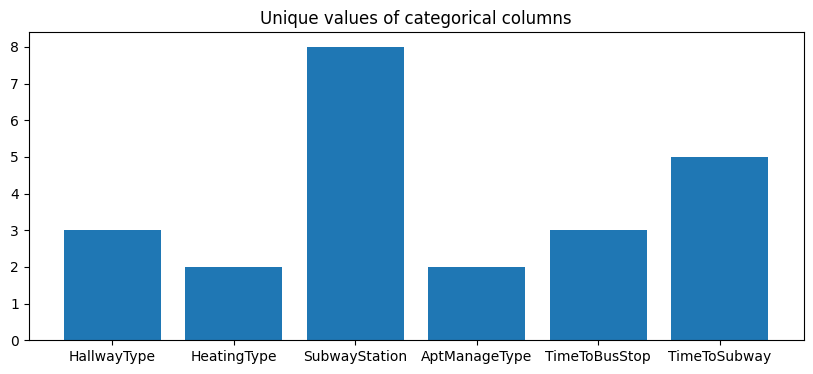

In [9]:
preprocessing.plot_bar(categorical_unique, "Unique values of categorical columns")

In [10]:
counts_by_label = dict(df["Label"].value_counts())
label_assignment = {0: "cheap (0)", 1:"average (1)", 2:"expensive (2)"}
counts_by_label = {label_assignment[key]: val for key, val in counts_by_label.items()}

In [11]:
ordinal_columns = ["TimeToBusStop", "TimeToSubway"]
nominal_columns = list(set(categorical_columns) - set(ordinal_columns))

## Check for outliers 

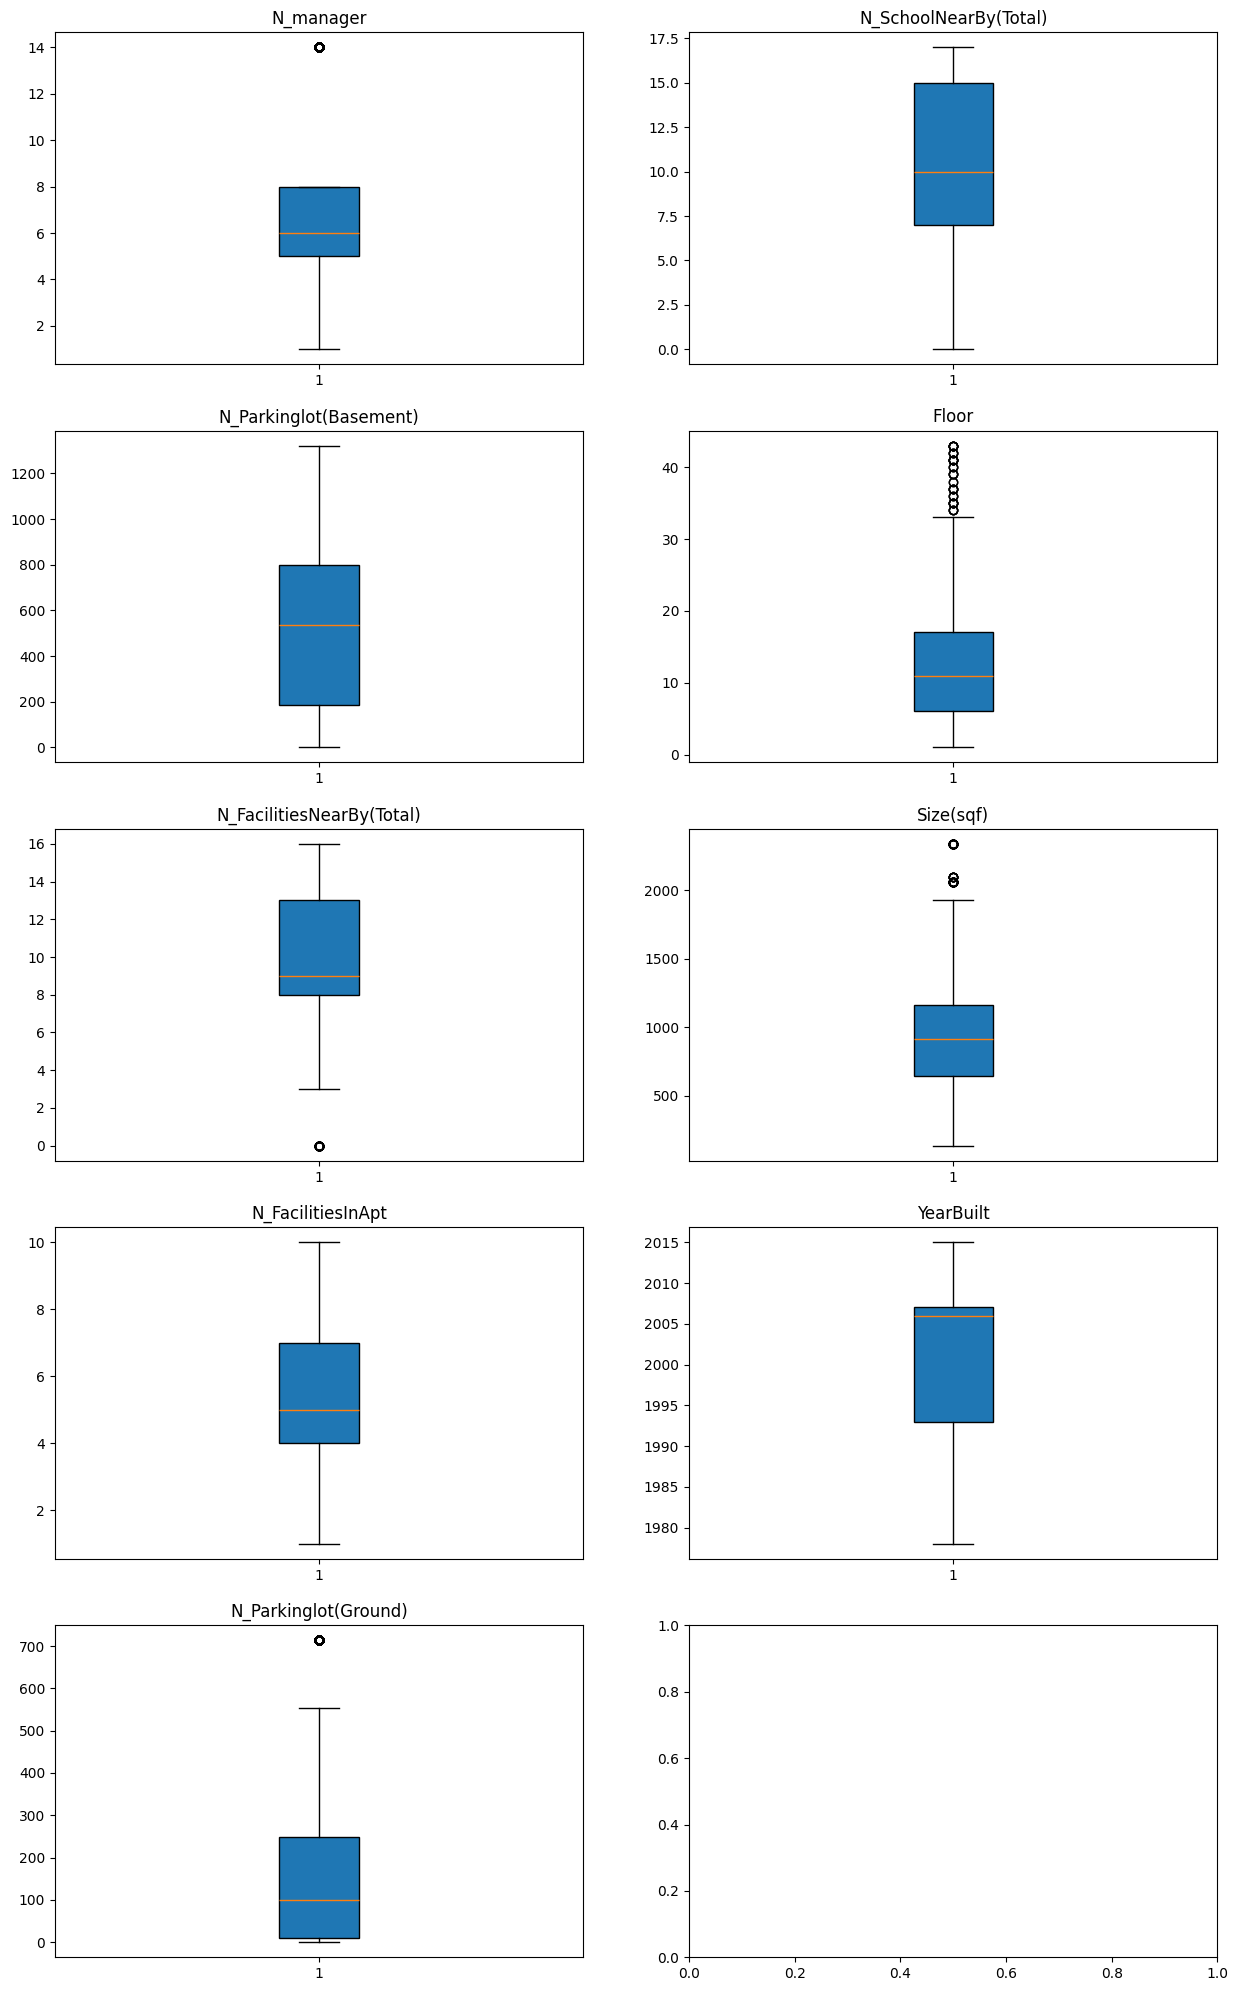

In [12]:
preprocessing.plot_boxplot(df, numeric_columns)

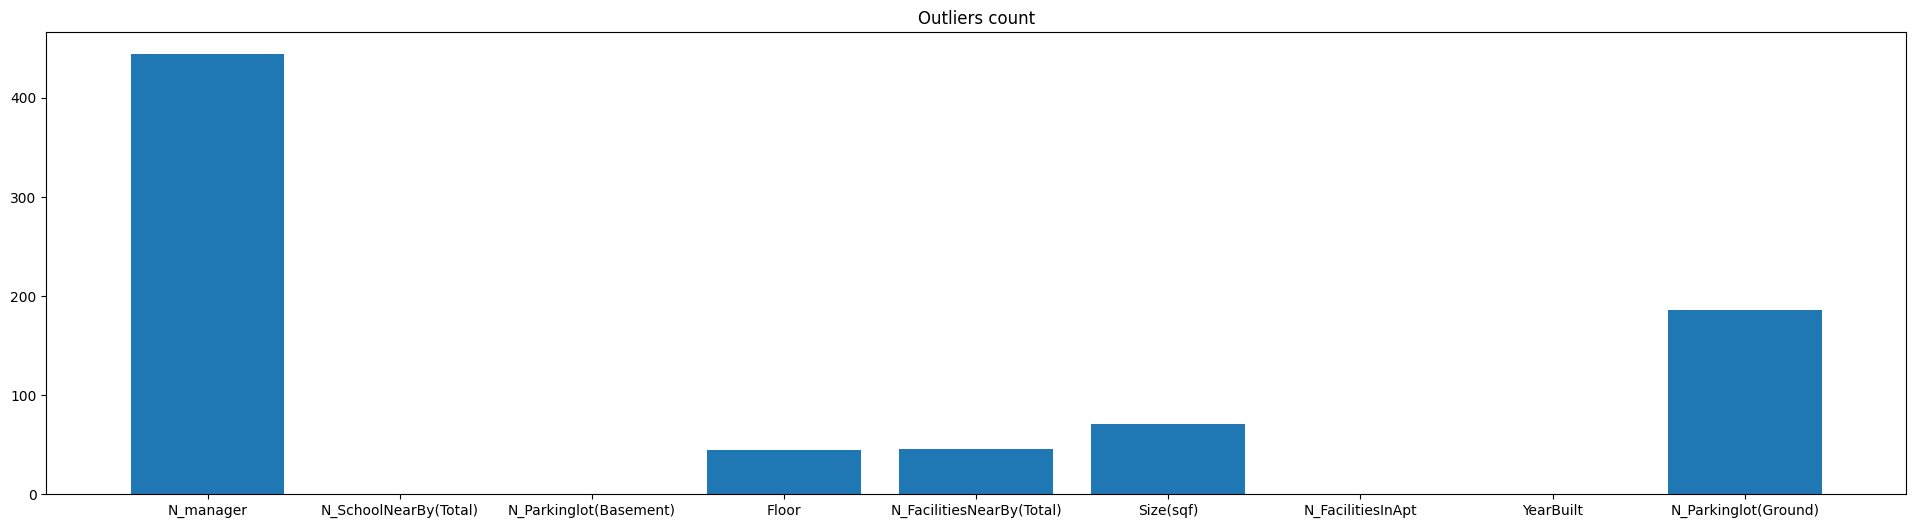

In [13]:
outliers_counts, outliers = preprocessing.check_outliers(df, numeric_columns)
preprocessing.plot_bar(outliers_counts, "Outliers count", size=(24, 6))

## Analyze if some features have normal distribution

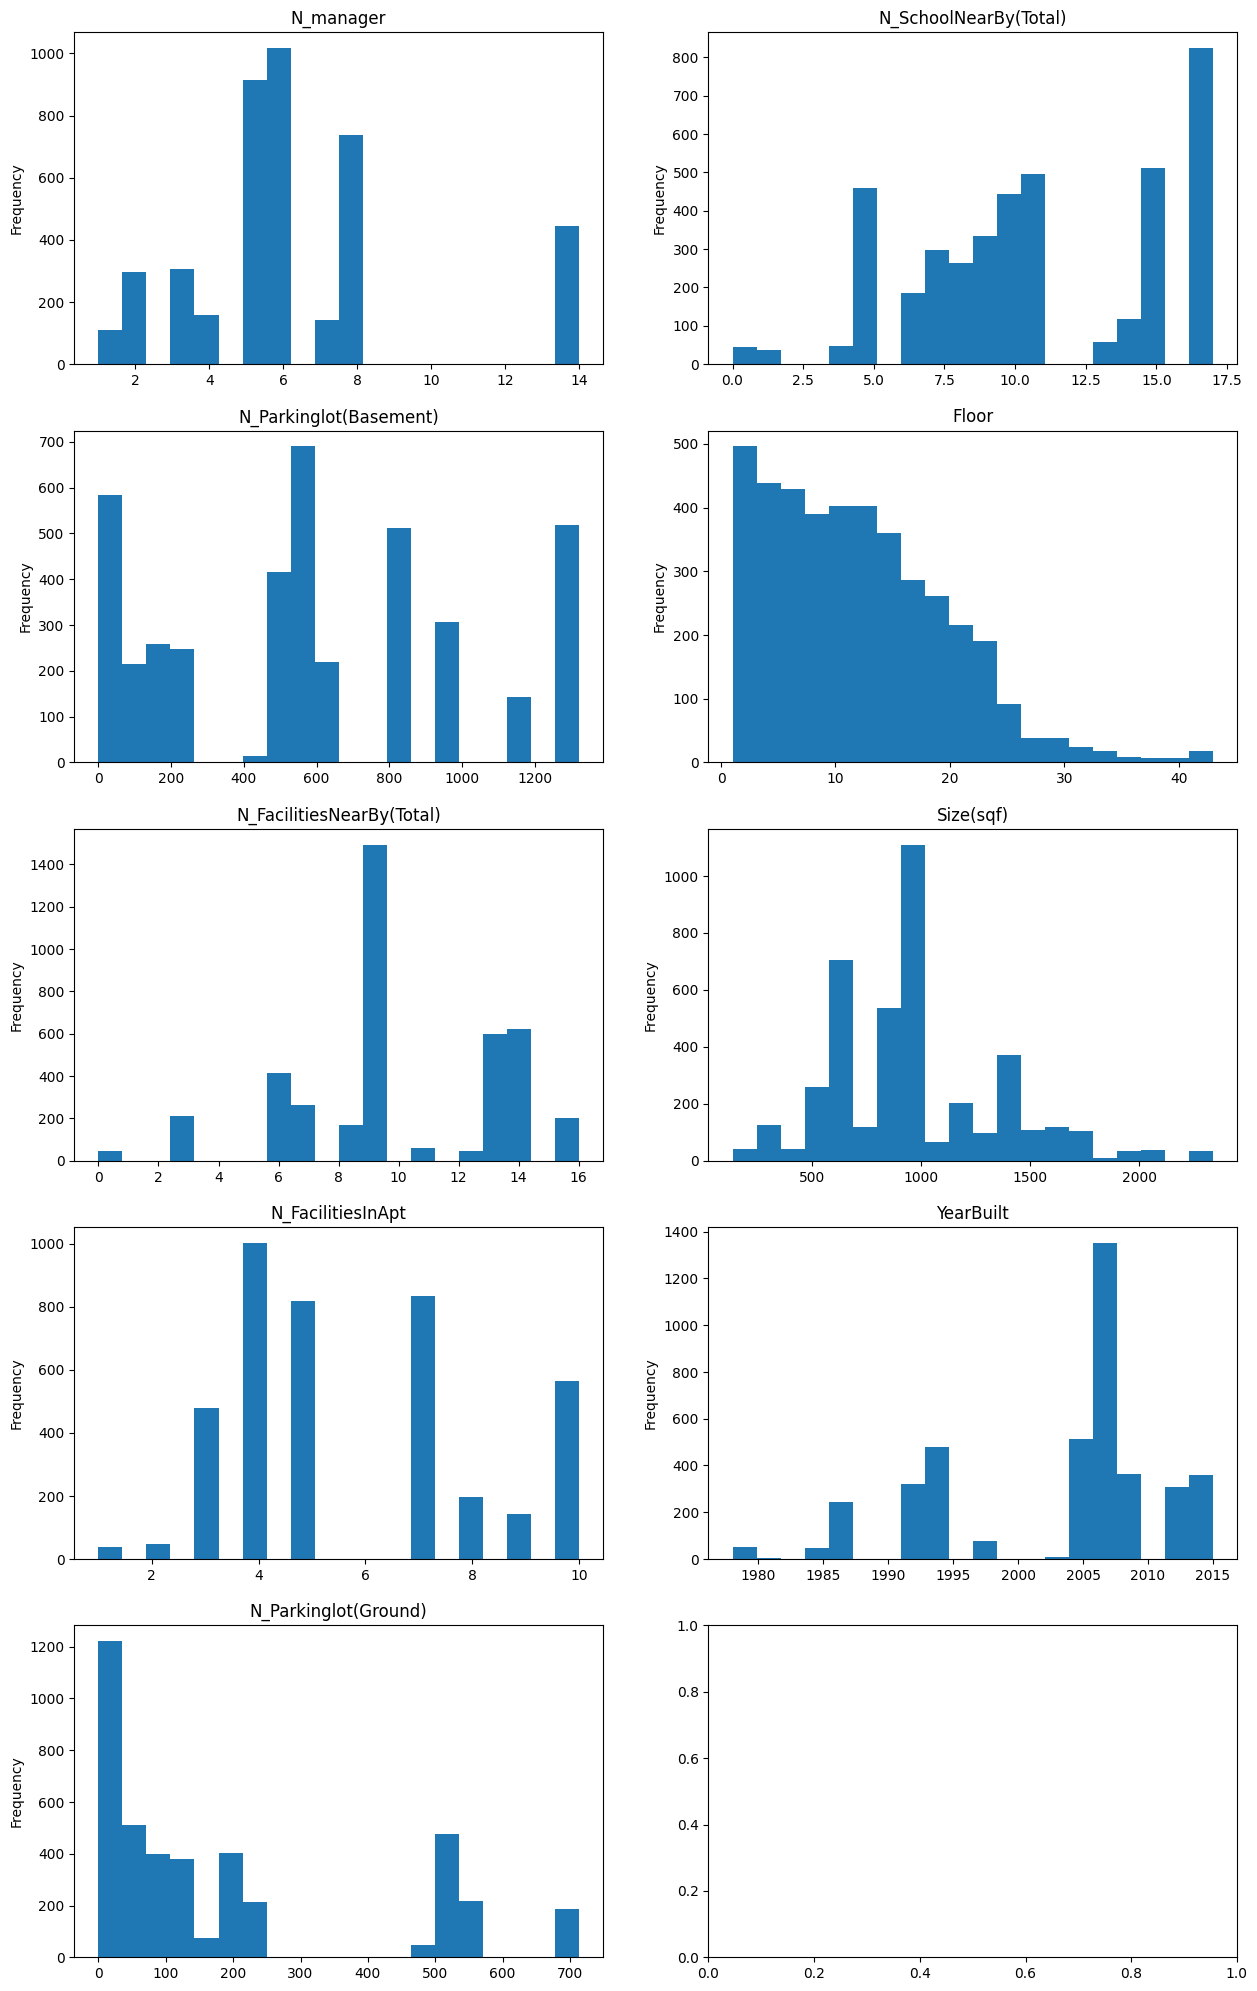

In [14]:
preprocessing.plot_histograms(df, numeric_columns)

In [15]:
preprocessing.shapiro_wilk(df, numeric_columns)

{'N_manager': 'not normally distributed',
 'N_SchoolNearBy(Total)': 'not normally distributed',
 'N_Parkinglot(Basement)': 'not normally distributed',
 'Floor': 'not normally distributed',
 'N_FacilitiesNearBy(Total)': 'not normally distributed',
 'Size(sqf)': 'not normally distributed',
 'N_FacilitiesInApt': 'not normally distributed',
 'YearBuilt': 'not normally distributed',
 'N_Parkinglot(Ground)': 'not normally distributed'}

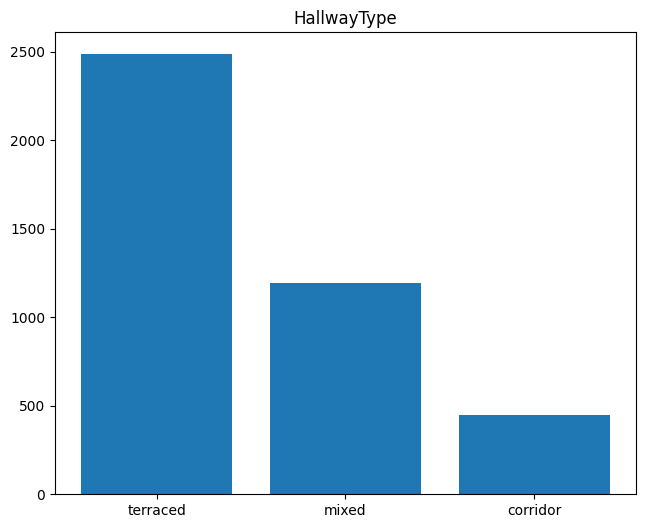

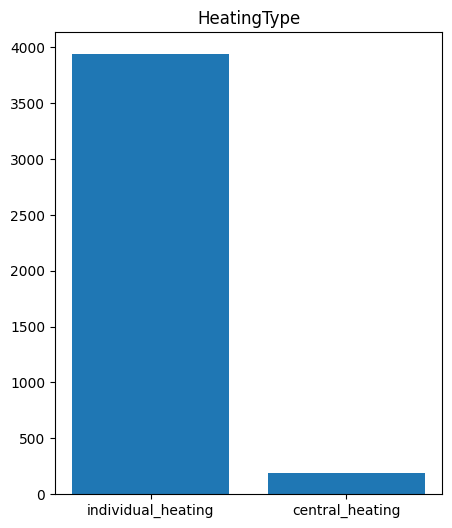

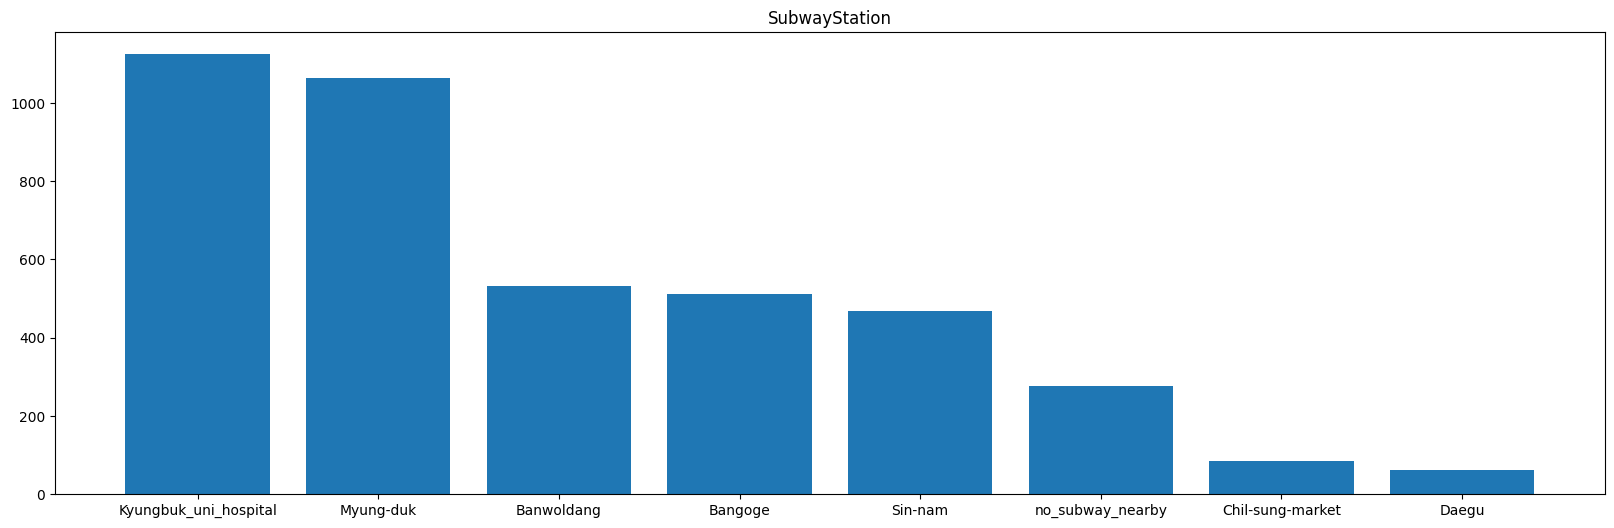

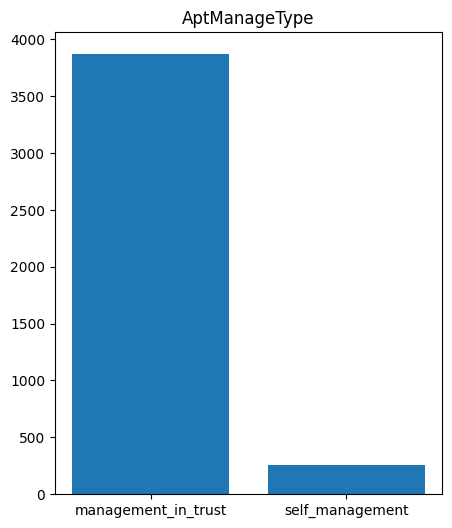

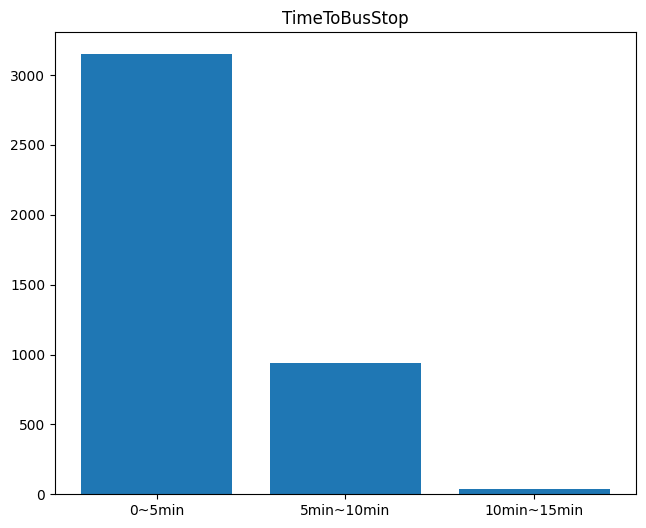

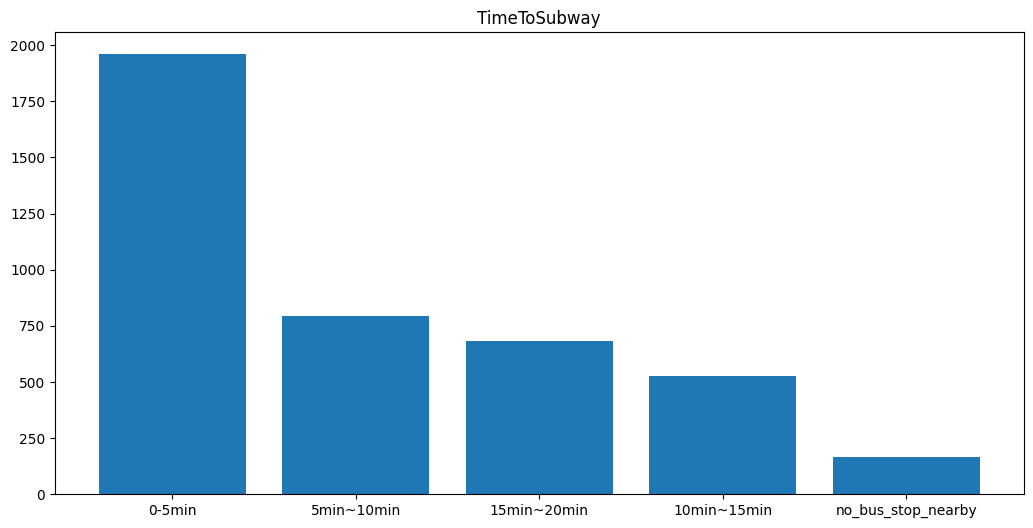

In [16]:
for col in categorical_columns:
    preprocessing.plot_bar(df[col].value_counts(), col, size=(2.5*len(df[col].value_counts()), 6))

## Analyzing the data imbalance

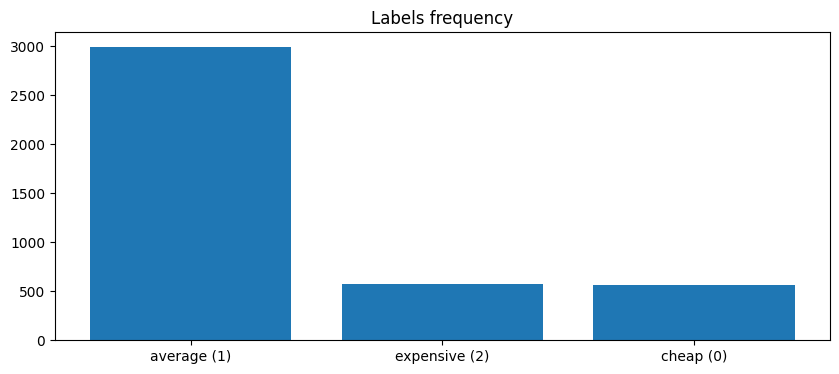

In [17]:
preprocessing.plot_bar(counts_by_label, "Labels frequency")

In [ ]:
X = df.drop(columns=["Label"])
y = df["Label"]
X, y = preprocessing.preprocess(X, numeric_columns, ordinal_columns, nominal_columns, y=y, oversample=True, undersample=False, random_state=42, echo_ordinal_counts=True)
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2)

TimeToBusStop value counts:
TimeToBusStop
0~5min         6649
5min~10min     2127
10min~15min     200
Name: count, dtype: int64
ordinal__TimeToBusStop value counts:
ordinal__TimeToBusStop
0.0    6649
1.0    2127
2.0     200
Name: count, dtype: int64
TimeToSubway value counts:
TimeToSubway
0-5min                4160
5min~10min            2064
15min~20min           1349
10min~15min           1238
no_bus_stop_nearby     165
Name: count, dtype: int64
ordinal__TimeToSubway value counts:
ordinal__TimeToSubway
0.0    4160
1.0    2064
3.0    1349
2.0    1238
4.0     165
Name: count, dtype: int64


In [19]:
weights = preprocessing.calculate_class_weights(train_y)
weights

tensor([0.9985, 1.0031, 0.9985])

# Model and training

In [20]:
architectures = [
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup = {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None}
train_accuracy, train_precision, train_recall, train_f1, val_accuracy, val_precision, val_recall, val_f1 = tune_architecture(train_x, train_y, val_x, val_y, architectures, training_setup, device)

Training model 0
Epoch: 0, loss: 0.9169332519569228
Epoch: 1, loss: 0.5474851447924048
Epoch: 2, loss: 0.46847969873816564
Epoch: 3, loss: 0.43258783801467016
Epoch: 4, loss: 0.4136142931153289
Epoch: 5, loss: 0.3922781195260782
Epoch: 6, loss: 0.37575718602248
Epoch: 7, loss: 0.36606613276279076
Epoch: 8, loss: 0.3534763191653564
Epoch: 9, loss: 0.34493983082011737
Epoch: 10, loss: 0.3399078623119709
Epoch: 11, loss: 0.33706904604899146
Epoch: 12, loss: 0.3289578017671551
Epoch: 13, loss: 0.32265967961433717
Epoch: 14, loss: 0.3224097910971768
Epoch: 15, loss: 0.3162215817554862
Epoch: 16, loss: 0.3114660694140249
Epoch: 17, loss: 0.31075975879103734
Epoch: 18, loss: 0.3100922931875803
Epoch: 19, loss: 0.3096373546703727
Epoch: 20, loss: 0.3092062518132471
Epoch: 21, loss: 0.3051002485825952
Epoch: 22, loss: 0.3029192784982445
Epoch: 23, loss: 0.30714144471999816
Epoch: 24, loss: 0.30417373064344966
Epoch: 25, loss: 0.2987627662652362
Epoch: 26, loss: 0.2952539792234919
Epoch: 27, los

In [21]:
architecture_results = pd.DataFrame({"models": architectures, "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.894568,0.894568,0.894568,0.894568,0.895323,0.895323,0.895323,0.895323
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.897075,0.897075,0.897075,0.897075,0.895880,0.895880,0.895880,0.895880
2,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.896379,0.896379,0.896379,0.896379,0.896993,0.896993,0.896993,0.896993
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.890947,0.890947,0.890947,0.890947,0.889755,0.889755,0.889755,0.889755
4,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.891504,0.891504,0.891504,0.891504,0.892539,0.892539,0.892539,0.892539
5,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.889833,0.889833,0.889833,0.889833,0.884744,0.884744,0.884744,0.884744


In [22]:
hyperparameters = [
    {"epochs": 60, "lr": 3e-2, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-2, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 128, "class_weights": None},
    ]
train_accuracy, train_precision, train_recall, train_f1, val_accuracy, val_precision, val_recall, val_f1 = tune_hyperparameters(train_x, train_y, val_x, val_y, architectures[0], hyperparameters, device)

Training model 0
Epoch: 0, loss: 0.4167125205286836
Epoch: 1, loss: 0.35024648601502445
Epoch: 2, loss: 0.32490781226516824
Epoch: 3, loss: 0.3224483051922469
Epoch: 4, loss: 0.3181742959845383
Epoch: 5, loss: 0.30093646563787374
Epoch: 6, loss: 0.2984556770693939
Epoch: 7, loss: 0.30395531008201365
Epoch: 8, loss: 0.29433547204310917
Epoch: 9, loss: 0.2856551677779814
Epoch: 10, loss: 0.2888251794914229
Epoch: 11, loss: 0.2932506369805969
Epoch: 12, loss: 0.300101210849475
Epoch: 13, loss: 0.29199042441570655
Epoch: 14, loss: 0.2825883586717918
Epoch: 15, loss: 0.2785719546069086
Epoch: 16, loss: 0.28178863108685587
Epoch: 17, loss: 0.27556408664821525
Epoch: 18, loss: 0.27260406038402457
Epoch: 19, loss: 0.2822787294873094
Epoch: 20, loss: 0.2849504544144183
Epoch: 21, loss: 0.2890488478989728
Epoch: 22, loss: 0.2797559571609033
Epoch: 23, loss: 0.27525266978593
Epoch: 24, loss: 0.2788176375680265
Epoch: 25, loss: 0.2796246416009633
Epoch: 26, loss: 0.2805010319679184
Epoch: 27, loss

In [23]:
hyperparameters_results = pd.DataFrame({"models": [architectures[0]]*len(hyperparameters), "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
hyperparameters_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.883148,0.883148,0.883148,0.883148,0.876392,0.876392,0.876392,0.876392
1,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.893036,0.893036,0.893036,0.893036,0.888641,0.888641,0.888641,0.888641
2,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.896797,0.896797,0.896797,0.896797,0.898664,0.898664,0.898664,0.898664
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.897493,0.897493,0.897493,0.897493,0.898664,0.898664,0.898664,0.898664
4,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.893733,0.893733,0.893733,0.893733,0.892539,0.892539,0.892539,0.892539
5,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.894429,0.894429,0.894429,0.894429,0.890312,0.890312,0.890312,0.890312
6,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.867827,0.867827,0.867827,0.867827,0.863586,0.863586,0.863586,0.863586
7,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.841922,0.841922,0.841922,0.841922,0.843541,0.843541,0.843541,0.843541


# Predict on test data

In [24]:
final_model = train_final_model(train_x, train_y, architectures[0], hyperparameters[5], device)

Training final model
Epoch: 0, loss: 1.1962197056987829
Epoch: 1, loss: 0.7928811792741742
Epoch: 2, loss: 0.6394947777714646
Epoch: 3, loss: 0.5652923787895002
Epoch: 4, loss: 0.5244481521740294
Epoch: 5, loss: 0.48065412567372906
Epoch: 6, loss: 0.4564955302497797
Epoch: 7, loss: 0.4350764819404535
Epoch: 8, loss: 0.41427398146244515
Epoch: 9, loss: 0.4057723105999461
Epoch: 10, loss: 0.3844249624955027
Epoch: 11, loss: 0.37730515839760764
Epoch: 12, loss: 0.3665380190339005
Epoch: 13, loss: 0.3584563204070978
Epoch: 14, loss: 0.35288176201937493
Epoch: 15, loss: 0.3514007439738826
Epoch: 16, loss: 0.34127156201161835
Epoch: 17, loss: 0.3306795533811837
Epoch: 18, loss: 0.3346043184661029
Epoch: 19, loss: 0.3239985701807758
Epoch: 20, loss: 0.32865102667557566
Epoch: 21, loss: 0.3166068457720572
Epoch: 22, loss: 0.31820894882344364
Epoch: 23, loss: 0.31917875769891235
Epoch: 24, loss: 0.31264803205665787
Epoch: 25, loss: 0.31040406410108534
Epoch: 26, loss: 0.30479199243219274
Epoch:

In [25]:
df_test = pd.read_csv("test_data.csv")
test_x = preprocessing.preprocess(df_test, numeric_columns, ordinal_columns, nominal_columns)

KeyError: "['Label'] not found in axis"

In [ ]:
test_preds = predict(final_model, test_x)
np.savetxt("preds.csv", test_preds, delimiter=",", fmt='%d')

# Conclusions